This notebook serves as an example of how to analyze a simulation trajectory using unsupervised techniques. Here, specifically, we'll be analyzing a simulation of cyclohexane conformations, simulated using quantum-espresso.

Before running this notebook, you will need to install:
    
- [ase](https://wiki.fysik.dtu.dk/ase/index.html)
- [scikit-learn](https://scikit-learn.org/)
- [scikit-matter](https://github.com/scikit-learn-contrib/scikit-matter)
- [chemiscope](https://chemiscope.org)

in addition to standard packages [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/).

## Loading Chemiscope widgets in Jupyter

Please make sure you have jupyter extensions enabled.

If at *any time* you are unable to load the chemiscope widgets in Jupyter, you can replace `chemiscope.show(` with `chemiscope.write_input('filename.json', ...` and upload the resulting file to [chemiscope.org](chemiscope.org).

In [1]:
import numpy as np
from ase.io import read
from matplotlib import pyplot as plt
import chemiscope
import scipy

import os

from matplotlib.gridspec import GridSpec
import pandas as pd
from pandas.plotting import table
from ase.geometry.analysis import Analysis as asis
from ase.neighborlist import NeighborList as NL
from ase.neighborlist import natural_cutoffs
import dataframe_image as dfi

names = {"C": "Carbon", "H": "Hydrogen"}
colors = {"H": (0.6, 0.6, 0.6), "C": (0.2, 0.2, 0.2)}

## Preparing the Data

### Read Data

Here we read in 5 MD trajectories and place them in a concatenated list `traj`.

`ranges` is storing the range of `traj` corresponding to each original file.
`conf_idx` is storing the location of the initial conformations.

`rgb_colors` is the set of colors used for each conformer, stored in rgba format.

In [2]:
# read in the frames from each MD simulation
traj = []
names = ["chair", "twist-boat", "boat", "half-chair", "planar"]
rgb_colors = [
    (0.13333333333333333, 0.47058823529411764, 0.7098039215686275),
    (0.4588235294117647, 0.7568627450980392, 0.34901960784313724),
    (0.803921568627451, 0.6078431372549019, 0.16862745098039217),
    (0.803921568627451, 0.13725490196078433, 0.15294117647058825),
    (0.4392156862745098, 0.2784313725490196, 0.611764705882353),
]

ranges = np.zeros((len(names), 2), dtype=int)
conf_idx = np.zeros(len(names), dtype=int)

for i, n in enumerate(names):
    frames = read(f"../../datasets/cyclohexane/{n}.xyz",":",)

    ranges[i] = (len(traj), len(traj) + len(frames))
    conf_idx[i] = len(traj)
    traj = [*traj, *frames]

In [3]:
# energies of the simulation frames, relative to the chair conformation
energy = np.array([a.info["relative_energy_eV"] for a in traj])

# energies of the known conformers, relative to the chair conformation
c_energy = np.array([traj[c].info["relative_energy_eV"] for c in conf_idx])

# extrema for the energies
max_e = max(energy)
min_e = min(energy)

Here we can confirm what our analysis will tell us: 

- the simulation starting in the planar conformation transitions to the chair conformation
- the simulations starting in the twist-boat, boat, and half-chair conformations ultimately get stuck in the twist formation.

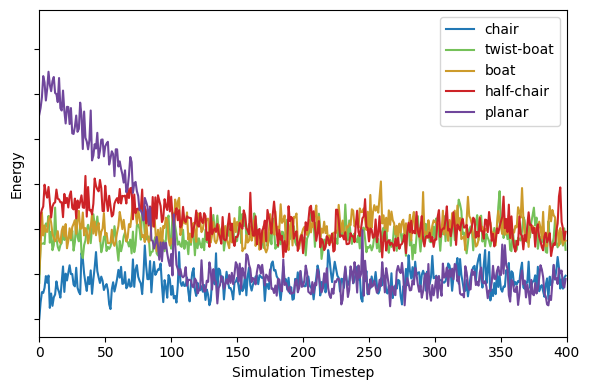

In [4]:
fig, ax = plt.subplots(1, figsize=(6, 4))

for n, c, r, rgb in zip(names, c_energy, ranges, rgb_colors):
    ax.plot(
        range(0, r[1] - r[0]), energy[r[0] : r[1]] - min_e, label=n, c=rgb, zorder=-1
    )

ax.legend()
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Energy")

ax.set_xlim([0, len(energy) // 5])
ax.set_ylim([-0.1, 1.25 * (max_e - min_e)])
ax.set_yticklabels([])

plt.tight_layout()
# plt.savefig('figures/Figure5/energy.png')
plt.show()

# STOP! Up until now we've just loaded some pre-computed descriptors. But now... let's do this ourself!

## Let's start with the first frame:

In [93]:
frame = traj[0]

positions = frame.positions
positions -= positions.min(axis=0)
order = list(sorted(range(len(frame)), key=lambda i: (-frame.numbers[i], *positions[i])))

positions = np.round(positions, 3)[order].tolist()

In [94]:
nl = NL(
    cutoffs=np.multiply(1, natural_cutoffs(frame)),
    bothways=True,
    self_interaction=False,
)
nl.update(frame)
a = asis(frame, nl=nl)
angles = a.get_angles("C", "C", "C", unique=True)
angle_vals = a.get_values(angles)

bonds = a.get_bonds("C","C", unique=True)
bond_vals = a.get_values(bonds)

# positions
positions_table = pd.DataFrame(
    positions,
    index=[
        f"{frame.symbols[i]}{frame.numbers[:i].tolist().count(n)+1}"
        for i, n in enumerate(frame.numbers)
    ],
    columns=[r"$x$", r"$y$", r"$z$"],
)
positions_table

,$x$,$y$,$z$
C1,1.028,2.139,1.600
C2,1.745,3.390,1.090
C3,1.753,0.891,1.090
C4,3.188,3.394,1.600
C5,3.195,0.896,1.600
C6,3.913,2.147,1.090
H1,0.000,2.136,1.237
H2,1.028,2.139,2.690
H3,1.229,4.278,1.453
H4,1.241,0.000,1.453


### These are our _internal coordinates_

### What about our bond angles?

In [95]:
# bond angles
bond_table = pd.DataFrame(
    np.transpose(np.round(angle_vals, 3)),
    index=["C{}-C{}-C{}".format(*np.sort(np.add(a, 1))) for a in angles[0]],
    columns=[r"Bond Angle ($^\circ$)"],
)
bond_table

,Bond Angle ($^\circ$)
C1-C2-C6,109.466
C1-C2-C3,109.471
C2-C3-C4,109.468
C3-C4-C5,109.470
C4-C5-C6,109.471
C1-C5-C6,109.470


### Let's take a look at the distance matrix (known as the Z-matrix)

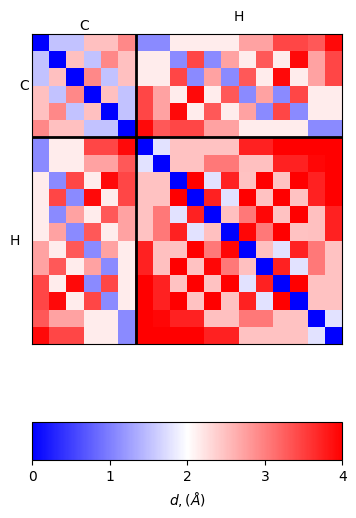

In [96]:
distances = np.array(
    [[np.linalg.norm(np.subtract(x, y)) for x in positions] for y in positions]
)

fig, (ax, cax) = plt.subplots(
    2, 1, figsize=(4,6), gridspec_kw=dict(height_ratios=(1.0, 0.1))
)
p = ax.imshow(distances, cmap="bwr", vmax=4.0)

ax.axvline(5.5, c="k", lw=2)
ax.axhline(5.5, c="k", lw=2)

ax.annotate("C", xy=(2.5, -0.5), xytext=(2.5, -1.0), ha="center", va="center")
ax.annotate("C", xy=(-0.5, 2.5), xytext=(-1.0, 2.5), ha="center", va="center")
ax.annotate("H", xy=(11.5, -0.5), xytext=(11.5, -1.5), ha="center", va="center")
ax.annotate("H", xy=(-0.5, 11.5), xytext=(-1.5, 11.5), ha="center", va="center")

ax.set_xticks([])
ax.set_yticks([])

plt.colorbar(
    p, label=r"$d, (\AA)$", ax=ax, cax=cax, orientation="horizontal", fraction=0.3
)

### If we know our neighborhood cutoffs, then we can make an _adjacency matrix_.

[]

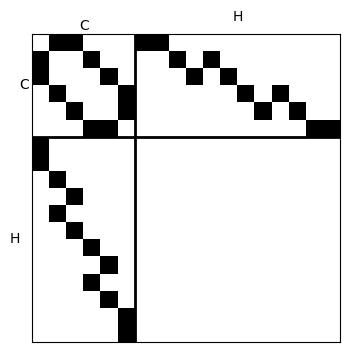

In [97]:
# adjacency-matrix
adjacency = np.array(
    [[np.linalg.norm(np.subtract(x, y)) for x in positions] for y in positions]
)
adjacency[adjacency==0] = np.inf

fig, ax = plt.subplots(
    1, 1, figsize=(4,4)
)

# Here we are selecting a cutoff of 1.6 Angstrom
p = ax.imshow(adjacency<1.6, cmap="Greys", vmax=1.0)

ax.axvline(5.5, c="k", lw=2)
ax.axhline(5.5, c="k", lw=2)

ax.annotate("C", xy=(2.5, -0.5), xytext=(2.5, -1.0), ha="center", va="center")
ax.annotate("C", xy=(-0.5, 2.5), xytext=(-1.0, 2.5), ha="center", va="center")
ax.annotate("H", xy=(11.5, -0.5), xytext=(11.5, -1.5), ha="center", va="center")
ax.annotate("H", xy=(-0.5, 11.5), xytext=(-1.5, 11.5), ha="center", va="center")

ax.set_xticks([])
ax.set_yticks([])

Next, the coulomb matrix!

In [98]:
from dscribe.descriptors import CoulombMatrix

cm = CoulombMatrix(n_atoms_max=18)
pd.DataFrame(cm.create(frame).reshape(18,18), columns = frame.symbols, index=frame.symbols)

,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H,H,H
C,36.858105,23.529768,23.529967,14.408975,12.288155,14.409055,2.785274,2.201120,2.201149,2.785212,5.504612,1.818802,2.785241,5.504530,1.740966,2.785197,1.532425,1.740957
C,23.529768,36.858105,14.409035,12.287898,14.408987,23.529653,5.504931,2.785158,1.818775,2.201120,2.785143,2.201198,1.740970,2.785177,2.785201,5.504496,1.740958,1.532410
C,23.529967,14.409035,36.858105,23.529069,14.409056,12.287815,2.201151,1.818746,2.785154,5.504774,2.785192,2.201150,5.504583,2.785243,1.532412,1.740961,1.740950,2.785157
C,14.408975,12.287898,23.529069,36.858105,23.529855,14.408584,1.818738,2.201123,5.504774,2.785154,2.201102,2.785148,2.785186,1.740957,1.740937,1.532411,2.785184,5.504486
C,12.288155,14.408987,14.409056,23.529855,36.858105,23.528421,2.201098,2.785212,2.785286,2.201120,1.818746,5.504532,1.740972,1.532426,2.785128,1.740957,5.504526,2.785196
C,14.409055,23.529653,12.287815,14.408584,23.528421,36.858105,2.785151,5.504941,2.201152,1.818715,2.201104,2.785157,1.532412,1.740955,5.504583,2.785255,2.785127,1.740914
H,2.785274,5.504931,2.201151,1.818738,2.201098,2.785151,0.500000,0.327616,0.253518,0.400238,0.327619,0.400249,0.268632,0.403289,0.403277,0.561833,0.268627,0.243695
H,2.201120,2.785158,1.818746,2.201123,2.785212,5.504941,0.327616,0.500000,0.400252,0.253514,0.400230,0.327620,0.243698,0.268628,0.561827,0.403281,0.403285,0.268628
H,2.201149,1.818775,2.785154,5.504774,2.785286,2.201152,0.253518,0.400252,0.500000,0.327615,0.400240,0.327618,0.403277,0.268632,0.268633,0.243700,0.403287,0.561807
H,2.785212,2.201120,5.504774,2.785154,2.201120,1.818715,0.400238,0.253514,0.327615,0.500000,0.327616,0.400243,0.561828,0.403285,0.243695,0.268628,0.268628,0.403281


### Question: How would you combine these descriptors from atom-level to become molecule-level?

### Now go back to cell 5 (STOP!) and see how your answers change for other configurations. The chair configuration is in traj[0], twist-boat in traj[400], boat in traj[800], half-chair in traj[1200], and planar in traj[1600].

# A small dive into SOAP

### For computing symmetrized representations, there are many, *many* different software packages that offer different benefits.

- [dscribe](https://singroup.github.io/dscribe/) is very user-friendly if you want to use off-the-shelf SOAP PowerSpectra (but that's about all that's available here).
- [librascal](https://github.com/lab-cosmo/librascal) is a power package for every variation of SOAP, Behler-Parinello symmetry functions, and other atom-centered representations. Unfortunately, its development has been discontinued since 2022, so proceed with caution.
- [rascaline](https://github.com/luthaf/rascaline) is another power package for every variation of SOAP, Behler-Parinello symmetry functions, and other atom-centered representations, but requires knowledge of the [equistore](https://github.com/lab-cosmo/equistore) format and has a steep learning curve.

## We're going to proceed cautiously with rascaline, but I encourage everyone to ask ample questions

In symmetrized descriptors, we have _hyperparameters_ that we can tune to mimic the physics of our system. In a 2-body SOAP descriptor, we tune:

- the `atomic_gaussian_width`, how large of a Gaussian we'd like to place on each atom, in Angstrom
- the `cutoff`, how far away from each atom we'd like to integrate
- the `radial_basis`, what set of [basis functions](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry/11.02%3A_Gaussian_Basis_Sets) to use for radial expansion
- the `max_radial` number of these basis functions to use
- the `cutoff_function` that we use to weight neighbors (this makes it so that atoms far away from our "central" one are weighted less)

Here are some good starting parameters:

In [99]:
from rascaline.calculators import SoapRadialSpectrum
representation = SoapRadialSpectrum(
    **{
        "atomic_gaussian_width": 0.3,
        "max_radial": 6,
        "cutoff": 3.5,
        "radial_basis": {"Gto": {}},
        "cutoff_function": {"ShiftedCosine": {"width": 0.8}},
        "center_atom_weight": 1.0,
    }
)

In [100]:
rep = representation.compute(frame)

# These two steps help with the equistore format
rep = rep.keys_to_samples('species_center')
rep = rep.keys_to_properties(["species_neighbor"])
x = rep.block().values

In [101]:
pd.DataFrame(x, index=frame.symbols, columns=['{}-neighbor, n={}'.format("CH"[i//6], i%6) for i in range(12)])

,"C-neighbor, n=0","C-neighbor, n=1","C-neighbor, n=2","C-neighbor, n=3","C-neighbor, n=4","C-neighbor, n=5","H-neighbor, n=0","H-neighbor, n=1","H-neighbor, n=2","H-neighbor, n=3","H-neighbor, n=4","H-neighbor, n=5"
C,0.107794,0.387799,0.355755,0.567162,0.360121,0.099282,0.992788,-0.079530,0.306791,0.235945,0.274294,0.056757
C,0.107770,0.387745,0.355804,0.567158,0.360121,0.099289,0.992787,-0.079526,0.306792,0.235964,0.274302,0.056756
C,0.107779,0.387773,0.355769,0.567152,0.360130,0.099288,0.992788,-0.079515,0.306801,0.235932,0.274299,0.056757
C,0.107785,0.387780,0.355771,0.567173,0.360124,0.099285,0.992789,-0.079515,0.306806,0.235946,0.274288,0.056753
C,0.107776,0.387749,0.355812,0.567172,0.360121,0.099292,0.992788,-0.079502,0.306810,0.235942,0.274303,0.056754
C,0.107788,0.387790,0.355757,0.567171,0.360135,0.099289,0.992789,-0.079508,0.306809,0.235940,0.274293,0.056754
H,0.972136,-0.117691,0.023211,0.375557,0.436640,0.116831,0.050653,0.200818,0.161395,0.314696,0.272305,0.079722
H,0.973126,-0.121113,0.027497,0.397077,0.339127,0.064064,0.057142,0.186981,0.194362,0.252461,0.087822,0.019566
H,0.972135,-0.117694,0.023191,0.375569,0.436646,0.116833,0.050627,0.200781,0.161405,0.314714,0.272322,0.079724
H,0.973125,-0.121115,0.027478,0.397089,0.339127,0.064064,0.057138,0.186976,0.194363,0.252460,0.087824,0.019566


For every neighboring species, we have a histogram across radial bases of where they fall!

But this is *VERY* hard to read in chart form, let's look at a plot.

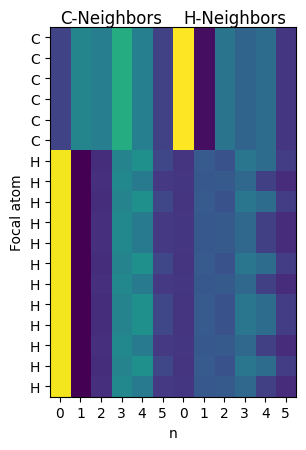

In [102]:
plt.imshow(x)
plt.gca().set_yticks(np.arange(len(frame)))
plt.gca().set_yticklabels(frame.symbols)
plt.gca().set_ylabel("Focal atom")

plt.gca().set_xticks(np.arange(len(x[0])))
plt.gca().set_xticklabels(['{}'.format(i%6) for i in range(12)])
plt.gca().set_xlabel("n")

plt.annotate("C-Neighbors",
            xy=(0.25, 1), xycoords='axes fraction',
            size=12, va="bottom", ha="center",)

plt.annotate("H-Neighbors",
            xy=(0.75, 1), xycoords='axes fraction',
            size=12, va="bottom", ha="center",)
plt.show()

When you get to this point, turn to your neighbors to discuss. If you need something to do while you wait, this is a good, albeit lengthy read:
    
https://doi.org/10.1021/acs.chemrev.1c00021

## But physics rarely relies on solely pair terms (at least good physics...)

When we go to higher body-orders, we also histogram over angular components through spherical harmonics. So we specify

- the `max_angular` number of spherical harmonics we expand over

The PowerSpectrum is a three-body descriptor, where we check two neighbors for each focal atom

In [103]:
from rascaline.calculators import SoapPowerSpectrum
representation = SoapPowerSpectrum(
    **{
        "atomic_gaussian_width": 0.3,
        "max_angular": 4,
        "max_radial": 6,
        "cutoff": 3.5,
        "radial_basis": {"Gto": {}},
        "cutoff_function": {"ShiftedCosine": {"width": 0.8}},
        "center_atom_weight": 1.0,
    }
)

In [104]:
rep = representation.compute(frame)

rep = rep.keys_to_samples('species_center')

# There are two neighbor species now! 
rep = rep.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])

[]

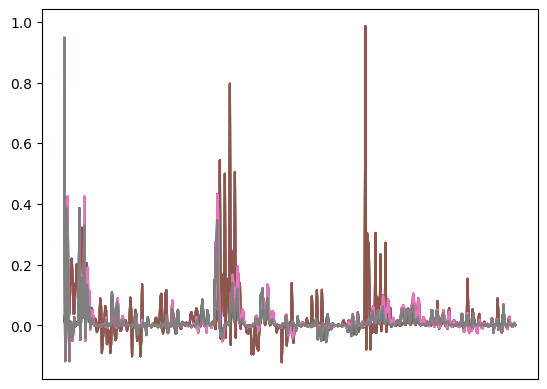

In [105]:
plt.plot(rep.block().values.T)

plt.gca().set_xticks([])

From a PCA, we can see that carbons are all very similar, but we have two types of hydrogens: in-plane and out-of-plane.

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(x)
t = pca.transform(x)

chemiscope.show([frame], properties={"t": t}, environments=[(0, i, 3.5) for i in range(len(frame))])

/Users/rca/mambaforge/lib/python3.10/site-packages/chemiscope/input.py:314: UserWarning: chemiscope behavior changed to no longer include properties from the structure objects. Use `chemiscope.extract_properties` to also visualize these properties ([closest_conformer, free_energy, energy, relative_energy_eV, color] and [forces, forces_eV_per_au])
  warnings.warn(


ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 18, "names": ["C", "C", "C", "C", "C",…

# Okay! I want to make SOAP descriptors like you did for the activities before. How do I do that?

First, we're only going to select carbon atoms as our focal atoms.

In [109]:
from equistore import Labels

values = []
for i, _ in enumerate(traj):
    for j in range(6): # carbons are indices 0-6
        values.append([i,j])

selection = Labels(
    names=["structure", "center"],
    values=np.array(values),
)

In [110]:
rep = representation.compute(traj, selected_samples=selection)

rep = rep.keys_to_samples('species_center')
rep = rep.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])

Next, we need to [standardize](https://scikit-matter.readthedocs.io/en/latest/examples/pcovr/PCovR_Scaling.html#sphx-glr-examples-pcovr-pcovr-scaling-py) our descriptors. Here we scale them all together, because their relative magnitude matters.

In [111]:
from skmatter.preprocessing import StandardFlexibleScaler
x = StandardFlexibleScaler(column_wise=False).fit_transform(rep.block().values)

Last, we'll split them by frame to help with later operations.

In [112]:
split_soaps = np.array(np.split(x, len(traj)))

# Et voila! 

In [114]:
np.linalg.norm(split_soaps - np.load('../../datasets/cyclohexane/cyclohexane_descriptors.npy'))

8.676323805062512e-15